In [60]:
import pandas as pd
import numpy as np

def clean_data(df):

    df_to_clean = df.copy(deep=True)
    # Hay varias columnas que para la porción de ML no nos interesan. Las vamos a borrar
    try:
        df_to_clean.drop(columns=["location", "created_at", "updated_at", "property_url", "address", "zonaprop_code"]
                , inplace=True)
    except KeyError:
        df_to_clean.drop(columns=["location", "property_url", "address", "zonaprop_code"]
                , inplace=True)


    df_to_clean["price"] = df_to_clean["price"].str.replace(".000", "000").replace(".0", "")
    df_to_clean["price"] = df_to_clean["price"].str.replace(".0", "")

    # Convert extracted columns to numeric types
    df_to_clean[["total_area", "rooms", "bedrooms", "bathrooms", "garages", "price", "antiquity"]] = (
        df_to_clean[["total_area", "rooms", "bedrooms", "bathrooms", "garages", "price", "antiquity"]]
        .apply(pd.to_numeric, errors="coerce")
    )

    # Vamos a comenzar a llenar información faltante
    # Si la propiedad tiene NaN en garage, asumimos que no tiene
    df_to_clean.loc[df_to_clean["garages"].isna(), "garages"] = 0

    # Borramos las propiedades que no tienen precio
    df_to_clean = df_to_clean[~df_to_clean.price.isna()]

    # Borramos todas las propiedades que no tienen información de metros cuadrados
    df_to_clean = df_to_clean[~df_to_clean.total_area.isna()]

    # Vamos a trabajar ahora con numeros de cuartos, baños y ambientes
    # Pasamos las descripciones a lowercase para facilitar busquedas de strings
    df_to_clean["description"] = df_to_clean["description"].str.lower()

    # Si la propiedad menciona monoambiente en su descripción, asumimos que tiene 1 baño, 1 cuarto y 1 ambiente
    df_to_clean.loc[df_to_clean["description"].str.contains("monoambiente") & df_to_clean["bedrooms"].isna(), "bedrooms"] = 1
    df_to_clean.loc[df_to_clean["description"].str.contains("monoambiente") & df_to_clean["rooms"].isna(), "rooms"] = 1
    df_to_clean.loc[df_to_clean["description"].str.contains("monoambiente") & df_to_clean["bathrooms"].isna(), "bathrooms"] = 1

    # Vamos a seguir rellenando "rooms" en base a la descripción
    def rooms_filler(description):
        possible_rooms = [1,2,3,4,5,6,7,8,9,10]
        possible_descriptions = ["{} ambientes", "{} amb", "{} dormitorios", 
                                "{} dorm", "{} ambiente", "{}amb", "{} dor", "{}dorm", "{}  ambientes"]

        for i in possible_rooms:
            for j in possible_descriptions:
                if j.format(i) in description:
                    return i

    df_to_clean.loc[df_to_clean["rooms"].isna(), "rooms"] = df_to_clean.loc[df_to_clean["rooms"].isna(), "description"].apply(rooms_filler)

    # Eliminamos las propiedades que no tienen ambientes luego de este procesamiento
    df_to_clean = df_to_clean[~df_to_clean.rooms.isna()]

    # Realizamos conversores de baños y dormitorios

    # En resumen, si no tenemos cantidad de cuartos, asignamos la cantidad de cuartos menos 1
    # Sabemos que en este punto todos los registros tienen valor en rooms
    df_to_clean.loc[df_to_clean["bedrooms"].isna(), "bedrooms"] = df_to_clean.loc[df_to_clean["bedrooms"].isna()]["rooms"] - 1

    # En caso de que nos de 0, asumimos que es 1 ya que sería un monoambiente
    df_to_clean.loc[df_to_clean["bedrooms"] == 0, "bedrooms"] = 1

    def bathroom_converter(rooms):
        one_bathroom_values = [1,2,3]
        two_bathroom_values = [4,5,6]

        if rooms in one_bathroom_values:
            return 1
        elif rooms in two_bathroom_values:
            return 2
        else:
            return 3
        
    df_to_clean.loc[df_to_clean["bathrooms"].isna(), "bathrooms"] = df_to_clean.loc[df_to_clean["bathrooms"].isna()]["rooms"].apply(bathroom_converter)

    # Para antiguedad, si no tenemos valor, llenamos con el valor promedio del resto de las antiguedades
    # en el barrio
    df_to_clean['antiquity'] = df_to_clean['antiquity'].fillna(
        df_to_clean.groupby('neighborhood')['antiquity'].transform('mean')
    )

    # Round up to the nearest natural number
    df_to_clean['antiquity'] = np.ceil(df_to_clean['antiquity'])

    # Para muchos casos no tenemos antiguedad por promedio. Tomamos información de Internet y las rellenamos
    avg_antiquity = {
        "Recoleta": 50,  # Historical, many buildings from early 20th century
        "Núñez": 40,  # Mix of older houses and newer developments
        "Palermo Hollywood": 30,  # Many mid-century and newer constructions
        "Puerto Madero": 20,  # Mostly new developments since the 1990s
        "Centro / Microcentro": 70,  # Historic center with older buildings
        "Las Cañitas": 40,  # Trendy area with a mix of old and new
        "Palermo Soho": 40,  # Similar to Hollywood, slightly older buildings
        "Monte Castro": 50,  # Traditional residential area
        "Almagro Norte": 60,  # Older residential area
        "Tribunales": 80,  # Historic legal and business district
        "San Nicolás": 70,  # Similar to Microcentro
        "Monserrat": 80,  # One of the oldest neighborhoods
        "Belgrano R": 50,  # Residential, mix of old and newer homes
        "Palermo Nuevo": 30,  # Newer part of Palermo
        "Palermo Chico": 40,  # Upscale, many mid-century properties
        "Belgrano Chico": 40,  # Similar to Palermo Chico
        "Palermo Viejo": 50,  # Older buildings, many renovated
        "Retiro": 70,  # Historic with some modern developments
        "La Paternal": 50,  # Older residential neighborhood
        "Caballito Norte": 60,  # Older family homes
        "Belgrano C": 50,  # Similar to Belgrano R
        "Caballito Sur": 60,  # Same as Norte
        "Parque Rivadavia": 60,  # Older buildings near park
        "Villa Pueyrredón": 50,  # Traditional middle-class area
        "Floresta Sur": 60,  # Mix of old houses and mid-century buildings
        "Primera Junta": 60,  # Similar to Caballito
        "Cid Campeador": 60,  # Similar to surrounding areas
        "Constitución": 80,  # Old and densely built
        "Botánico": 40,  # Around the gardens, mix of styles
        "Lomas de Núñez": 30,  # Newer developments
        "Distrito Quartier": 20,  # Newly developed
        "Temperley": 70,  # Older suburb
        "Flores Sur": 60,  # Similar to Floresta
        "Almagro Sur": 60,  # Similar to Norte
        "Flores Norte": 60,  # Same as Sur
        "La Boca": 80,  # Historic with some modern projects
        "Parque Chas": 50,  # Traditional middle-class area
        "Floresta Norte": 60,  # Similar to Sur
        "Agronomía": 50,  # Near university, mix of styles
        "Otro": 50,  # Placeholder for undefined neighborhoods
        "Puerto Retiro": 70,  # Near historic Retiro
        "Barrio Parque": 40,  # Upscale, mid-century
        "Barrio Chino": 30,  # Newer commercial developments
        "Naón": 50,  # Mix of older homes
        "Parque Avellaneda": 60,  # Similar to Parque Chas
        "Catalinas": 20,  # Modern skyscrapers
        "Los Perales": 50,  # Traditional residential
        "Villa Riachuelo": 50,  # Outlying older area
        "Barrio Parque General Belgrano": 50  # Older homes, quieter
    }

    def antiquity_filler(neighborhood):
        return avg_antiquity.get(neighborhood, 50)

    df_to_clean.loc[df_to_clean["antiquity"].isna(), "antiquity"] = df_to_clean.loc[df_to_clean["antiquity"].isna()]["neighborhood"].apply(antiquity_filler)

    # Borramos la columna "expenses ya que no tenemos un buen uso por ahora"
    df_to_clean.drop(columns=["expenses"], inplace=True)

    # Borramos la descripción ya que no la vamos a usar en el modelo
    df_to_clean.drop(columns=["description"], inplace=True)

    # El precio tiene que ser mayor a 0 obligatoriamente
    print("Registros antes de borrar los precios menores a 1000: ", len(df_to_clean))
    df_to_clean = df_to_clean[df_to_clean["price"] > 1000]
    print("Registros después de borrar los precios menores a 1000: ", len(df_to_clean))

    # El área total debe ser mayor a 0 obligatoriamente
    print("Registros antes de borrar las superficies menores a 10: ", len(df_to_clean))
    df_to_clean = df_to_clean[df_to_clean["total_area"] > 10]
    print("Registros después de borrar las superficies menores a 10: ", len(df_to_clean))

    # Vemos que el precio tiene una distribución asimétrica a la derecha
    # Vamos a ahora quitar los outliers en relacion al precio
    print(f"Limpieza precio")

    # Calculamos los cuantiles
    Q1 = df_to_clean['price'].quantile(0.25)
    Q3 = df_to_clean['price'].quantile(0.75)
    IQR = Q3 - Q1

    # Calculamos los límites a partir de los cuantiles
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"Linea de borrado mínima': {lower_bound}")
    print(f"Linea de borrado máxima': {upper_bound}")

    # identificamos los outliers y luego los borramos
    outliers = df_to_clean[(df_to_clean['price'] < lower_bound) | (df_to_clean['price'] > upper_bound)]
    print(f"\nSe detectó la siguiente cantidad de outliers: {outliers.shape[0]}")

    # Remove outliers from the DataFrame
    df_to_clean = df_to_clean[(df_to_clean['price'] >= lower_bound) & (df_to_clean['price'] <= upper_bound)]

    print("\nNueva cantidad de datos luego de borrado:")
    print(df_to_clean.shape)

    # Tenemos un problema similar con la superficie total. Tomamos un approach similar

    # Vemos que el precio tiene una distribución asimétrica a la derecha
    # Vamos a ahora quitar los outliers en relacion al precio

    # Calculamos los cuantiles
    print(f"Limpieza superficie total")

    Q1 = df_to_clean['total_area'].quantile(0.25)
    Q3 = df_to_clean['total_area'].quantile(0.75)
    IQR = Q3 - Q1

    # Calculamos los límites a partir de los cuantiles
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"Linea de borrado mínima': {lower_bound}")
    print(f"Linea de borrado máxima': {upper_bound}")

    # identificamos los outliers y luego los borramos
    outliers = df_to_clean[(df_to_clean['total_area'] < lower_bound) | (df_to_clean['total_area'] > upper_bound)]
    print(f"\nSe detectó la siguiente cantidad de outliers: {outliers.shape[0]}")

    # Remove outliers from the DataFrame
    df_to_clean = df_to_clean[(df_to_clean['total_area'] >= lower_bound) & (df_to_clean['total_area'] <= upper_bound)]

    print("\nNueva cantidad de datos luego de borrado:")
    print(df_to_clean.shape)

    return df_to_clean

In [88]:
import pandas as pd
from dotenv import load_dotenv
import boto3
import os
from io import StringIO

# Debemos normalizar un poco la información antes de generar métricas.
# Además, definimos algunas constantes

BARRIO = "PALERMO"
AMBIENTES = 3
HISTORIC_FILE_PATH = "Files/alquilerescaba_202501.xlsx"

load_dotenv()
session = boto3.Session(
    aws_access_key_id=os.getenv('AWS_ACCESS_KEY_ID'),
    aws_secret_access_key=os.getenv('AWS_SECRET_ACCESS_KEY_ID')
)
s3_client = session.client('s3')
BUCKET_NAME = os.getenv('BUCKET_NAME')


In [89]:
# Agarramos de zonaprop los dos archivos mas nuevos

def extract_date(file):
    date_part = file.split('_')[-1].replace('.csv', '')  # Get "04022025"
    return pd.to_datetime(date_part, format="%d%m%Y")  # Convert to datetime

files = s3_client.list_objects_v2(Bucket=BUCKET_NAME)
sub_files = list()
for file in files["Contents"]:
    if ("/ZonaProp/STG" in file["Key"]) and (".csv" in file["Key"]):
        sub_files.append(file["Key"])

sorted_files = sorted(sub_files, key=extract_date, reverse=True)
newest_files = sorted_files[:2]

newest_file = newest_files[0]
previous_file = newest_files[1]

response = s3_client.get_object(Bucket=BUCKET_NAME, Key=newest_file)
csv_data = response['Body'].read().decode('utf-8')  # Convert bytes to string
df_new = pd.read_csv(StringIO(csv_data))

response = s3_client.get_object(Bucket=BUCKET_NAME, Key=previous_file)
csv_data = response['Body'].read().decode('utf-8')  # Convert bytes to string
df_old = pd.read_csv(StringIO(csv_data))


In [90]:
df_new.to_csv("Files/new.csv", index=False)
df_old.to_csv("Files/old.csv", index=False)

In [91]:
# Debido a que no nos coinciden los barrios de la info histórica con los de ZonaProp, vamos a hacer un mapeo
# y normalización.

import pandas as pd
from difflib import get_close_matches

# Lista de valores permitidos
valid_neighborhoods = [
    'ALMAGRO', 'BALVANERA', 'BELGRANO', 'CABALLITO', 'COLEGIALES', 'DEVOTO',
    'FLORES', 'MONTSERRAT', 'NUNEZ', 'PALERMO', 'PARQUE PATRICIOS', 'PUERTO MADERO',
    'RECOLETA', 'RETIRO', 'SAN NICOLAS', 'SAN TELMO', 'VILLA CRESPO', 'VILLA DEL PARQUE', 'VILLA URQUIZA'
]

# Función para mapear los barrios
def map_neighborhood(neighborhood):
    neighborhood = neighborhood.upper()  # Convertimos a mayúsculas para estandarizar
    
    # Mapeos directos conocidos
    manual_mappings = {
        'MONSERRAT': 'MONTSERRAT',
        'NUÑEZ': 'NUNEZ',
        'CONGRESO': 'BALVANERA',
        'BARRIO NORTE': 'RECOLETA',
        'TRIBUNALES': 'SAN NICOLAS',
        'MICROCENTRO': 'SAN NICOLAS',
        'CENTRO / MICROCENTRO': 'SAN NICOLAS',
        'BARRACAS': 'PARQUE PATRICIOS',
        'CONSTITUCIÓN': 'SAN TELMO',
        'POMPEYA': 'PARQUE PATRICIOS',
        'MATADEROS': 'FLORES',
        'LINIERS': 'FLORES',
        'VERSALLES': 'VILLA URQUIZA',
        'VILLA SOLDATI': 'PARQUE PATRICIOS',
        'VILLA RIACHUELO': 'PARQUE PATRICIOS',
        'VILLA LUGANO': 'PARQUE PATRICIOS'
    }
    
    if neighborhood in manual_mappings:
        return manual_mappings[neighborhood]
    
    # Buscar coincidencias aproximadas
    match = get_close_matches(neighborhood, valid_neighborhoods, n=1, cutoff=0.6)
    return match[0] if match else 'OTRO'

# Aplicar la función de mapeo
df_old['normalized_neighborhood'] = df_old['neighborhood'].apply(map_neighborhood)
df_new['normalized_neighborhood'] = df_new['neighborhood'].apply(map_neighborhood)

# Dropeamos los que tienen valor OTRO
df_old = df_old[df_old['normalized_neighborhood'] != 'OTRO']
df_new = df_new[df_new['normalized_neighborhood'] != 'OTRO']

df_new

,property_url,zonaprop_code,price,expenses,address,location,description,neighborhood,total_area,rooms,bedrooms,bathrooms,garages,antiquity,normalized_neighborhood
0,https://www.zonaprop.com.ar/propiedades/clasif...,55432076,4800000.0,1,NaN,Capital Federal,Contacto: G A Ver datos Excelente departamento...,Belgrano,125.0,3.0,2.0,3.0,1.0,NaN,BELGRANO
1,https://www.zonaprop.com.ar/propiedades/clasif...,55525585,2940000.0,500.000,NaN,Capital Federal,Alquiler Semipiso de 5 amb ubicado en Belgrano...,Palermo,189.0,5.0,3.0,3.0,1.0,NaN,PALERMO
2,https://www.zonaprop.com.ar/propiedades/clasif...,55469522,420.000,97.000,NaN,Capital Federal,Alquiler vivienda o comercialedificio ubicado ...,Tribunales,44.0,2.0,1.0,1.0,NaN,NaN,SAN NICOLAS
3,https://www.zonaprop.com.ar/propiedades/clasif...,55264598,1440000.0,300.000,NaN,Belgrano,Excelente departamento en esquina con vistas m...,Belgrano R,105.0,4.0,3.0,2.0,1.0,NaN,BELGRANO
5,https://www.zonaprop.com.ar/propiedades/clasif...,55478576,320.000,65.000,NaN,Capital Federal,Monoambiente en Barrio Norte1 ambiente al fren...,Barrio Norte,20.0,1.0,NaN,1.0,NaN,NaN,RECOLETA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12653,https://www.zonaprop.com.ar/propiedades/clasif...,55210964,580.000,NaN,NaN,Capital Federal,Luminoso 2 ambientes amueblado en edificio de ...,Recoleta,40.0,2.0,1.0,1.0,NaN,NaN,RECOLETA
12654,https://www.zonaprop.com.ar/propiedades/clasif...,55162861,400.000,NaN,NaN,Capital Federal,"1 ambiente luminoso, piso unidad tipo S. to...",Centro / Microcentro,34.0,1.0,NaN,1.0,NaN,NaN,SAN NICOLAS
12656,https://www.zonaprop.com.ar/propiedades/clasif...,55444259,820.000,250.000,NaN,Capital Federal,Muy buen departamento de tres ambientes con de...,Villa Crespo,77.0,4.0,3.0,2.0,NaN,NaN,VILLA CRESPO
12657,https://www.zonaprop.com.ar/propiedades/clasif...,55455426,1.000.000,NaN,NaN,Capital Federal,Propiedades para soñar,Barrio Norte,NaN,NaN,NaN,NaN,NaN,NaN,RECOLETA


In [92]:
df_new = clean_data(df_new)
df_new.head()

Hi
Registros antes de borrar los precios menores a 1000:  10895
Registros después de borrar los precios menores a 1000:  10496
Registros antes de borrar las superficies menores a 10:  10496
Registros después de borrar las superficies menores a 10:  10474
Limpieza precio
Linea de borrado mínima': -225000.0
Linea de borrado máxima': 1575000.0

Se detectó la siguiente cantidad de outliers: 1524

Nueva cantidad de datos luego de borrado:
(8950, 9)
Limpieza superficie total
Linea de borrado mínima': 4.5
Linea de borrado máxima': 88.5

Se detectó la siguiente cantidad de outliers: 479

Nueva cantidad de datos luego de borrado:
(8471, 9)


,price,neighborhood,total_area,rooms,bedrooms,bathrooms,garages,antiquity,normalized_neighborhood
2,420000.0,Tribunales,44.0,2.0,1.0,1.0,0.0,80.0,SAN NICOLAS
5,320000.0,Barrio Norte,20.0,1.0,1.0,1.0,0.0,50.0,RECOLETA
6,650000.0,Belgrano,42.0,2.0,1.0,1.0,0.0,50.0,BELGRANO
9,500000.0,Recoleta,43.0,2.0,1.0,1.0,0.0,50.0,RECOLETA
10,450000.0,Centro / Microcentro,45.0,2.0,1.0,1.0,0.0,70.0,SAN NICOLAS


In [93]:
df_old = clean_data(df_old)
df_old.head()

Hi
Registros antes de borrar los precios menores a 1000:  11247
Registros después de borrar los precios menores a 1000:  10848
Registros antes de borrar las superficies menores a 10:  10848
Registros después de borrar las superficies menores a 10:  10824
Limpieza precio
Linea de borrado mínima': -225000.0
Linea de borrado máxima': 1575000.0

Se detectó la siguiente cantidad de outliers: 1533

Nueva cantidad de datos luego de borrado:
(9291, 9)
Limpieza superficie total
Linea de borrado mínima': 3.0
Linea de borrado máxima': 91.0

Se detectó la siguiente cantidad de outliers: 431

Nueva cantidad de datos luego de borrado:
(8860, 9)


,price,neighborhood,total_area,rooms,bedrooms,bathrooms,garages,antiquity,normalized_neighborhood
1,420000.0,Tribunales,44.0,2.0,1.0,1.0,0.0,80.0,SAN NICOLAS
3,1440000.0,Recoleta,85.0,3.0,2.0,1.0,1.0,50.0,RECOLETA
4,800000.0,Colegiales,44.0,2.0,1.0,1.0,0.0,50.0,COLEGIALES
5,1320000.0,Palermo,70.0,2.0,1.0,1.0,0.0,50.0,PALERMO
7,1020000.0,Recoleta,48.0,2.0,1.0,1.0,0.0,50.0,RECOLETA


# Información de Mercado

In [94]:
df_barrio = df_new[df_new["normalized_neighborhood"] == BARRIO]

# Cantidad total de propiedades en el barrio
total_properties = len(df_barrio)
print("Total propiedades en el barrio:", total_properties)

# Precio promedio de las propiedades en el barrio
average_price = df_barrio["price"].mean()
print("Precio promedio de las propiedades en el barrio:", average_price)

# Precio minimo de las propiedades en el barrio
min_price = df_barrio["price"].min()
print("Precio mínimo de las propiedades en el barrio:", min_price)

# Precio máximo de las propiedades en el barrio
max_price = df_barrio["price"].max()
print("Precio máximo de las propiedades en el barrio:", max_price)

df_barrio_amb = df_barrio[df_barrio["rooms"] == AMBIENTES]

# Cantidad total de propiedades en el barrio con ambientes
total_properties_amb = len(df_barrio_amb)
print("Total propiedades en el barrio con ambientes:", total_properties_amb)

# Precio promedio de las propiedades en el barrio con ambientes
average_price_amb = df_barrio_amb["price"].mean()
print("Precio promedio de las propiedades en el barrio con ambientes:", average_price_amb)

# Precio minimo de las propiedades en el barrio con ambientes
min_price_amb = df_barrio_amb["price"].min()
print("Precio mínimo de las propiedades en el barrio con ambientes:", min_price_amb)

# Precio máximo de las propiedades en el barrio con ambientes
max_price_amb = df_barrio_amb["price"].max()
print("Precio máximo de las propiedades en el barrio con ambientes:", max_price_amb)

Total propiedades en el barrio: 1500
Precio promedio de las propiedades en el barrio: 682969.8666666667
Precio mínimo de las propiedades en el barrio: 60000.0
Precio máximo de las propiedades en el barrio: 1560000.0
Total propiedades en el barrio con ambientes: 223
Precio promedio de las propiedades en el barrio con ambientes: 892242.1524663677
Precio mínimo de las propiedades en el barrio con ambientes: 450000.0
Precio máximo de las propiedades en el barrio con ambientes: 1560000.0


# Gráfico de Barras Promedio de precio por amb

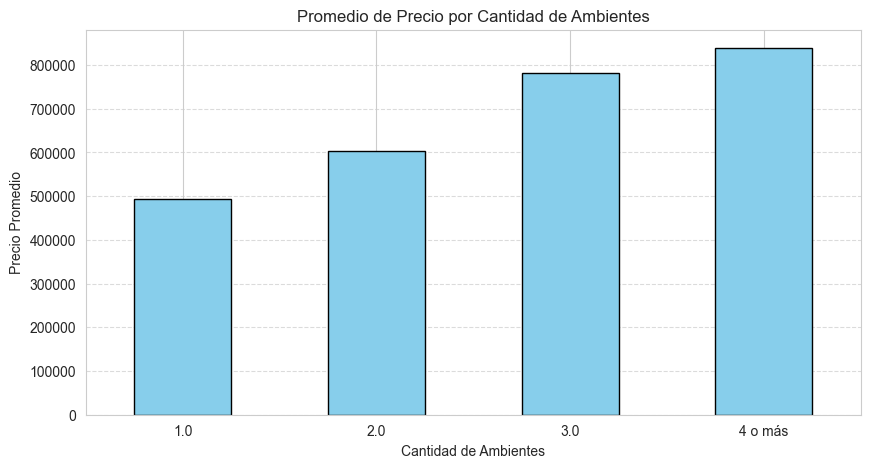

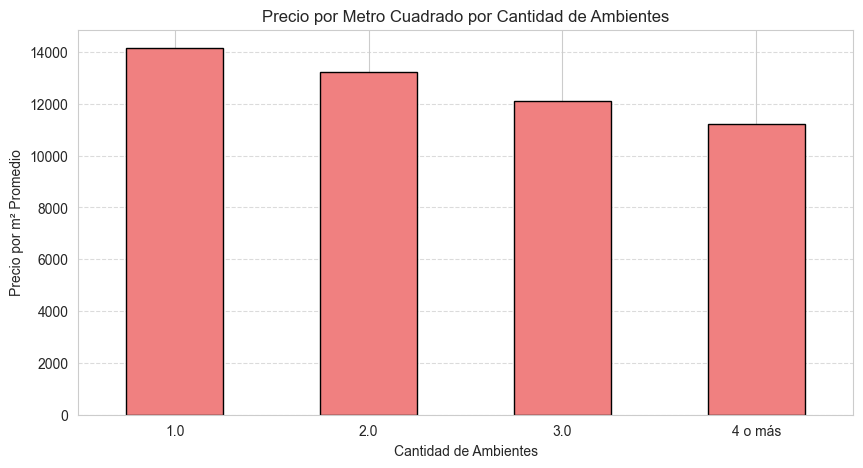

In [95]:
import pandas as pd
import matplotlib.pyplot as plt

df_filtered = df_new.copy(deep=True)

# Agrupar las habitaciones en 1, 2, 3, y "4 o más"
df_filtered['room_category'] = df_filtered['rooms'].apply(lambda x: x if x < 4 else '4 o más')
df_filtered['price'] = pd.to_numeric(df_filtered['price'], errors='coerce')  # Convertir a número, manejando errores


# Calcular el promedio de precio por cantidad de ambientes
avg_price = df_filtered.groupby('room_category')['price'].mean()

# Calcular el precio por metro cuadrado por cantidad de ambientes
df_filtered['price_per_m2'] = df_filtered['price'] / df_filtered['total_area']
avg_price_per_m2 = df_filtered.groupby('room_category')['price_per_m2'].mean()

# Gráfico de barras - Promedio de precio por cantidad de ambientes
plt.figure(figsize=(10, 5))
avg_price.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Promedio de Precio por Cantidad de Ambientes')
plt.xlabel('Cantidad de Ambientes')
plt.ylabel('Precio Promedio')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Gráfico de barras - Precio por metro cuadrado por cantidad de ambientes
plt.figure(figsize=(10, 5))
avg_price_per_m2.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title('Precio por Metro Cuadrado por Cantidad de Ambientes')
plt.xlabel('Cantidad de Ambientes')
plt.ylabel('Precio por m² Promedio')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

room_category
1.0        5.578179e+05
2.0        7.061664e+05
3.0        8.922422e+05
4 o más    1.006786e+06
Name: price, dtype: float64


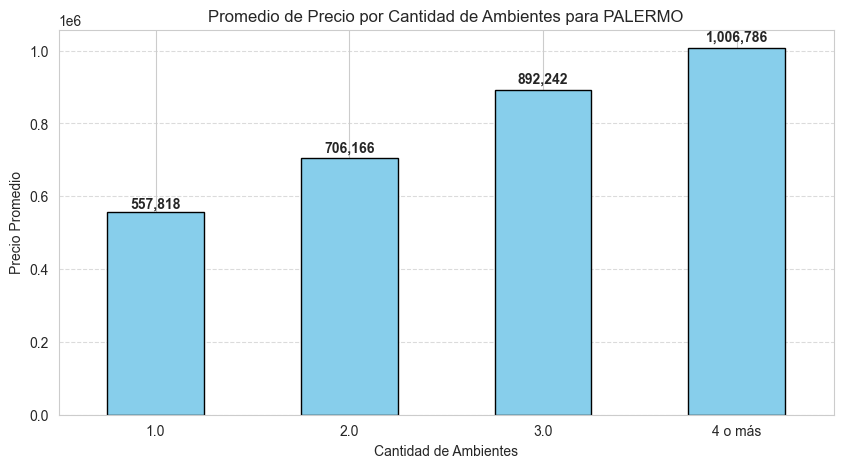

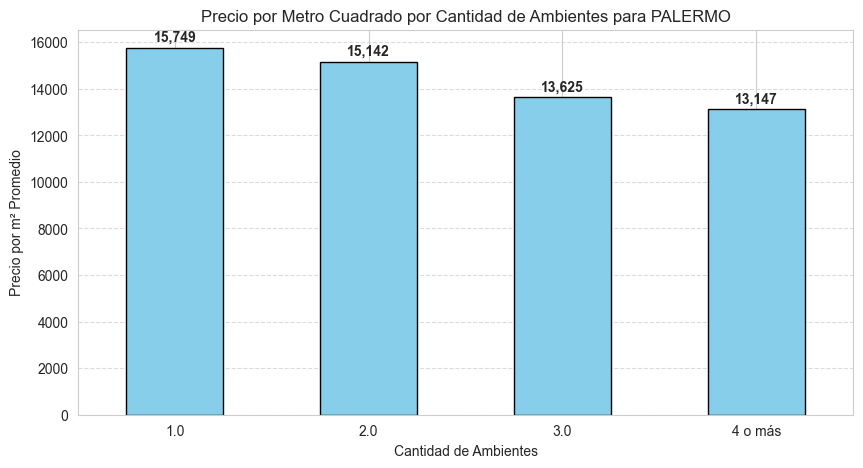

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

df_filtered = df_new.copy(deep=True)
df_filtered = df_filtered[df_filtered["normalized_neighborhood"] == BARRIO]

# Agrupar las habitaciones en 1, 2, 3, y "4 o más"
df_filtered['room_category'] = df_filtered['rooms'].apply(lambda x: x if x < 4 else '4 o más')
df_filtered['price'] = pd.to_numeric(df_filtered['price'], errors='coerce')  # Convertir a número, manejando errores


# Calcular el promedio de precio por cantidad de ambientes
avg_price = df_filtered.groupby('room_category')['price'].mean()
print(avg_price)

# Calcular el precio por metro cuadrado por cantidad de ambientes
df_filtered['price_per_m2'] = df_filtered['price'] / df_filtered['total_area']
avg_price_per_m2 = df_filtered.groupby('room_category')['price_per_m2'].mean()

# Gráfico de barras - Promedio de precio por cantidad de ambientes
plt.figure(figsize=(10, 5))
ax = avg_price.plot(kind='bar', color='skyblue', edgecolor='black')
# Agregar valores encima de cada barra
for i, value in enumerate(avg_price):
    ax.text(i, value + (value * 0.02), f'{value:,.0f}', ha='center', fontsize=10, fontweight='bold')
plt.title(f'Promedio de Precio por Cantidad de Ambientes para {BARRIO}')
plt.xlabel('Cantidad de Ambientes')
plt.ylabel('Precio Promedio ($)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Gráfico de barras - Precio por metro cuadrado por cantidad de ambientes
plt.figure(figsize=(10, 5))
ax = avg_price_per_m2.plot(kind='bar', color='skyblue', edgecolor='black')
# Agregar valores encima de cada barra
for i, value in enumerate(avg_price_per_m2):
    ax.text(i, value + (value * 0.02), f'{value:,.0f}', ha='center', fontsize=10, fontweight='bold')
plt.title('Precio por Metro Cuadrado por Cantidad de Ambientes para {}'.format(BARRIO))
plt.xlabel('Cantidad de Ambientes')
plt.ylabel('Precio por m² Promedio ($)')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Gráfico de evolución histórica de precio del metro cuadrado por barrio

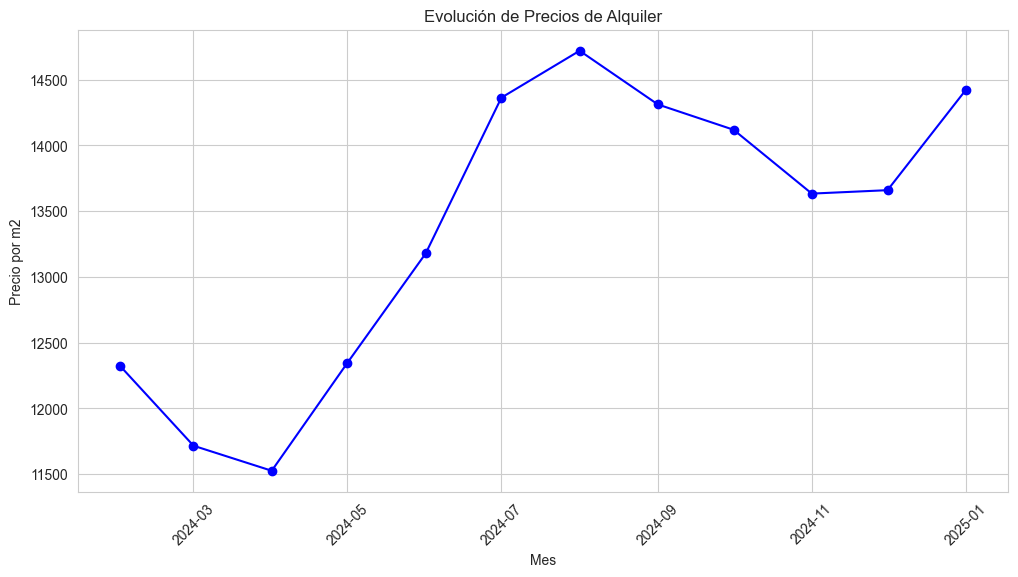

In [101]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el archivo
file_path = HISTORIC_FILE_PATH
df = pd.read_excel(file_path)

# Quitamos del dataframe los locales y oficinas
# Dataframe negar la condición
df = df[~df['Inmueble'].isin(["Oficina", "Local"])]
df.drop(columns=['Inmueble'], inplace=True)

# Convertir la columna 'Mes' a formato datetime
df['Mes'] = pd.to_datetime(df['Mes'], format='%Y-%m')
df.head()

df_grouped = df.groupby(['Mes', 'Barrio']).agg({'Mediana.por.m2.a.precios.corrientes': 'mean'}).reset_index()
df_grouped.head()

from datetime import datetime, timedelta

# Get the current date
current_date = datetime.today()

# Subtract one year
one_year_ago = current_date.replace(year=current_date.year - 1)

# Format as 'YYYY-MM'
formatted_date = one_year_ago.strftime('%Y-%m')

df_grouped = df_grouped[df_grouped['Mes'] >= formatted_date]

# Definir colores para cada zona
colores = {
    BARRIO: "blue"
}

# Crear la figura y el gráfico
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

for zona, color in colores.items():
    subset = df_grouped[df_grouped['Barrio'] == zona]
    plt.plot(subset['Mes'], subset['Mediana.por.m2.a.precios.corrientes'], marker='o', label=zona, color=color)

# Configurar etiquetas y título
plt.xlabel("Mes")
plt.ylabel("Precio por m2")
plt.title("Evolución de Precios de Alquiler")
#plt.legend()
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.show()


# Diagrama Pie distribución BARRIO

/var/folders/nh/hlj82q8x3lb09bztb9v347pwp22f50/T/ipykernel_66246/1809376780.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['room_category'] = df_filtered['rooms'].apply(lambda x: x if x < 4 else '4 o más')


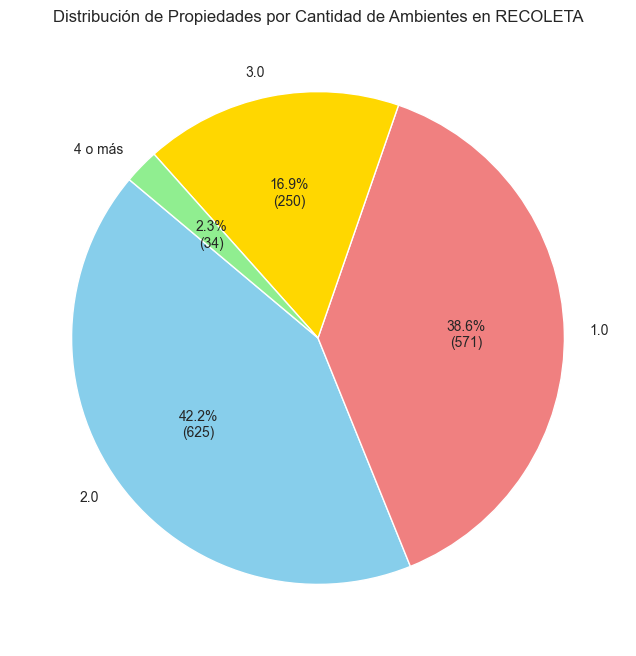

In [74]:
# Filtrar el DataFrame por barrio
df_filtered = df_new[df_new['normalized_neighborhood'] == BARRIO]

# Agrupar las habitaciones en 1, 2, 3 y "4 o más"
df_filtered['room_category'] = df_filtered['rooms'].apply(lambda x: x if x < 4 else '4 o más')

# Contar la cantidad de propiedades por categoría de ambientes
room_distribution = df_filtered['room_category'].value_counts()

# Función para mostrar tanto el porcentaje como la cantidad
def autopct_format(pct, all_vals):
    absolute = int(round(pct/100.*sum(all_vals)))
    return f"{pct:.1f}%\n({absolute})"

# Generar gráfico de torta (pie chart)
plt.figure(figsize=(8, 8))
plt.pie(
    room_distribution, 
    labels=room_distribution.index, 
    autopct=lambda pct: autopct_format(pct, room_distribution), 
    colors=['skyblue', 'lightcoral', 'gold', 'lightgreen'], 
    startangle=140
)

plt.title(f'Distribución de Propiedades por Cantidad de Ambientes en {BARRIO}')
plt.show()

# Diagrama Pie distribución CABA

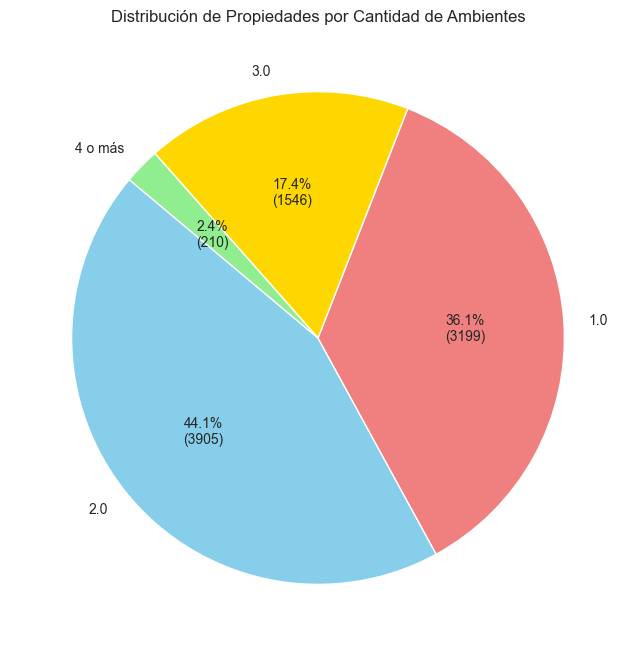

In [75]:
# Filtrar el DataFrame por barrio
df_filtered = df_new.copy(deep=True)

# Agrupar las habitaciones en 1, 2, 3 y "4 o más"
df_filtered['room_category'] = df_filtered['rooms'].apply(lambda x: x if x < 4 else '4 o más')

# Contar la cantidad de propiedades por categoría de ambientes
room_distribution = df_filtered['room_category'].value_counts()

# Función para mostrar tanto el porcentaje como la cantidad
def autopct_format(pct, all_vals):
    absolute = int(round(pct/100.*sum(all_vals)))
    return f"{pct:.1f}%\n({absolute})"

# Generar gráfico de torta (pie chart)
plt.figure(figsize=(8, 8))
plt.pie(
    room_distribution, 
    labels=room_distribution.index, 
    autopct=lambda pct: autopct_format(pct, room_distribution), 
    colors=['skyblue', 'lightcoral', 'gold', 'lightgreen'], 
    startangle=140
)
plt.title(f'Distribución de Propiedades por Cantidad de Ambientes')
plt.show()

# Gráfico de Barras apiladas

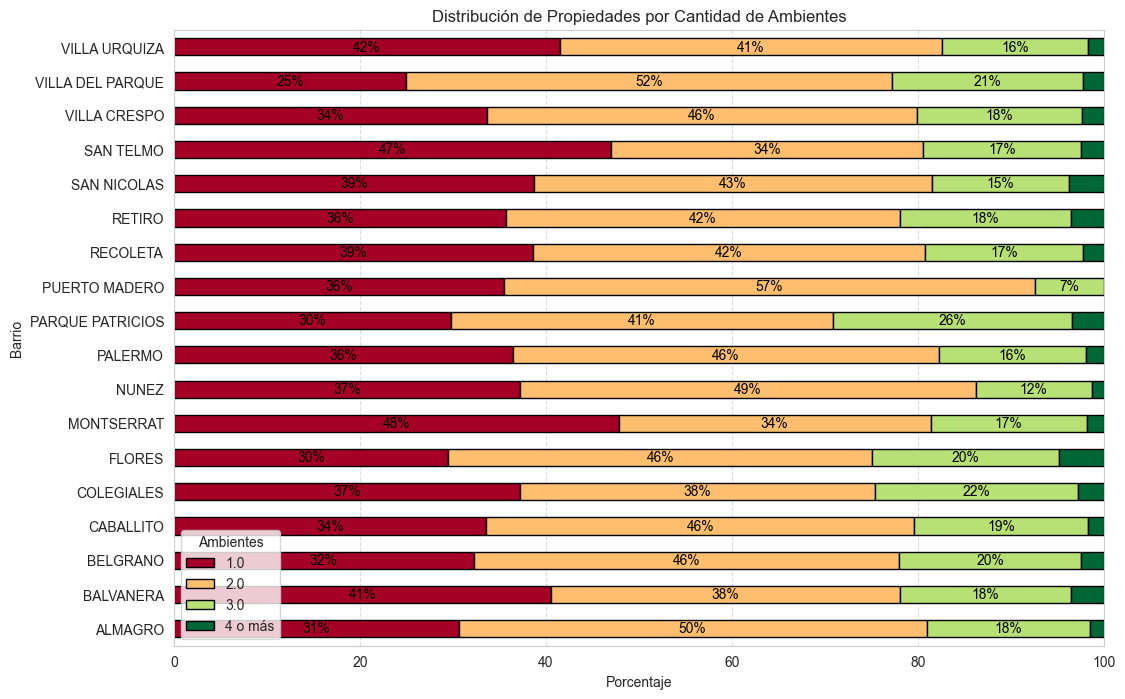

In [80]:
import pandas as pd
import matplotlib.pyplot as plt

df = df_new.copy(deep=True)

# Definir categorías de ambientes
def categorize_rooms(rooms):
    return rooms if rooms < 4 else '4 o más'

# Agrupar las habitaciones en 1, 2, 3 y "4 o más"
df['room_category'] = df['rooms'].apply(categorize_rooms)

# Contar la cantidad de propiedades por barrio y categoría de ambientes
room_distribution = df.groupby('normalized_neighborhood')['room_category'].value_counts().unstack(fill_value=0)

# Convertir a porcentajes por barrio
room_distribution_percentage = room_distribution.div(room_distribution.sum(axis=1), axis=0) * 100

# Crear gráfico de barras apiladas normalizadas
fig, ax = plt.subplots(figsize=(12, 8))
room_distribution_percentage.plot(kind='barh', stacked=True, colormap='RdYlGn', ax=ax, edgecolor='black')

# Agregar etiquetas de porcentaje dentro de las barras
for i, (index, row) in enumerate(room_distribution_percentage.iterrows()):
    cumulative = 0
    for col in room_distribution_percentage.columns:
        percentage = row[col]
        if percentage > 5:  # Mostrar solo si el espacio es suficiente
            ax.text(cumulative + percentage / 2, i, f"{percentage:.0f}%", ha='center', va='center', fontsize=10, color='black')
        cumulative += percentage

# Personalización del gráfico
plt.xlabel("Porcentaje")
plt.ylabel("Barrio")
plt.title("Distribución de Propiedades por Cantidad de Ambientes")
plt.legend(title="Ambientes")
plt.xlim(0, 100)
plt.grid(axis='x', linestyle='--', alpha=0.7)

plt.show()